In [14]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import copy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
games_df = pd.read_csv('games.csv')
games_df.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,...,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,...,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


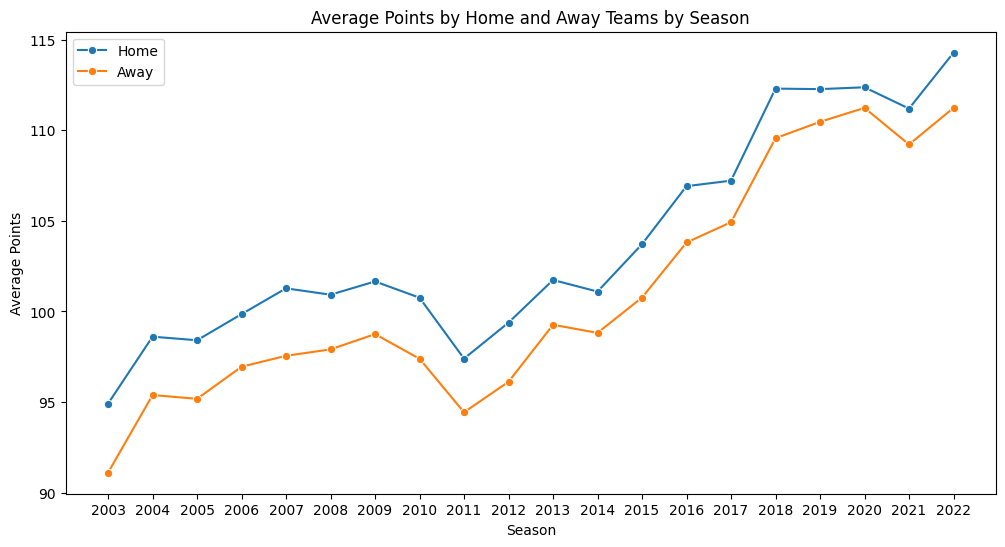

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert SEASON to integer
games_df['SEASON'] = games_df['SEASON'].astype(int)

# Calculate the average points by home and away teams by season
avg_points_by_season = games_df.groupby('SEASON')[['PTS_home', 'PTS_away']].mean()

# Plot the average points by home and away teams by season
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_points_by_season.reset_index(), x='SEASON', y='PTS_home', marker='o', label='Home')
sns.lineplot(data=avg_points_by_season.reset_index(), x='SEASON', y='PTS_away', marker='o', label='Away')
plt.title('Average Points by Home and Away Teams by Season')
plt.xlabel('Season')
plt.ylabel('Average Points')
plt.xticks(avg_points_by_season.index)  # Ensure x-axis ticks are integers
plt.legend()
plt.show()


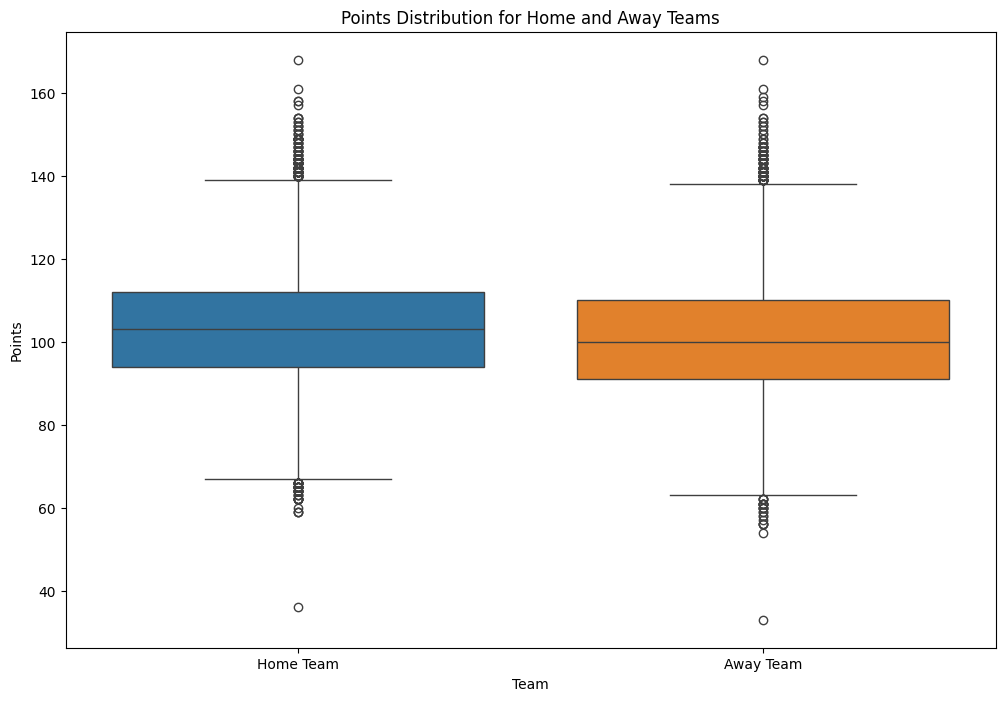

In [17]:
# Plot box plots of points distribution for home and away teams
plt.figure(figsize=(12, 8))
sns.boxplot(data=games_df[['PTS_home', 'PTS_away']])
plt.title('Points Distribution for Home and Away Teams')
plt.xlabel('Team')
plt.ylabel('Points')
plt.xticks([0, 1], ['Home Team', 'Away Team'])
plt.show()


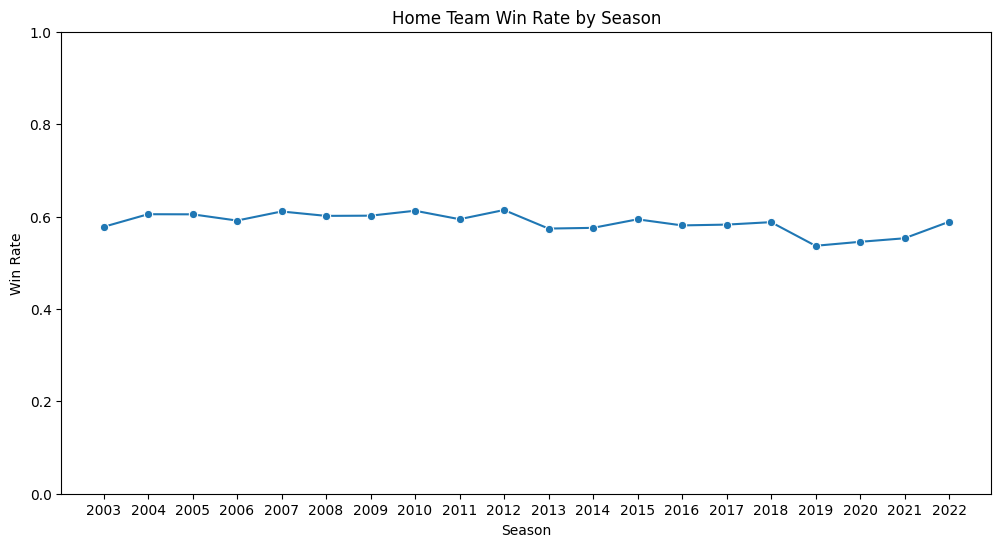

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert SEASON to integer
games_df['SEASON'] = games_df['SEASON'].astype(int)

# Calculate the win rate by season
win_rate_by_season = games_df.groupby('SEASON')['HOME_TEAM_WINS'].mean()

# Plot the home team win rate by season
plt.figure(figsize=(12, 6))
sns.lineplot(x=win_rate_by_season.index, y=win_rate_by_season.values, marker='o')
plt.title('Home Team Win Rate by Season')
plt.xlabel('Season')
plt.ylabel('Win Rate')
plt.ylim(0, 1)
plt.xticks(win_rate_by_season.index)  # Ensure x-axis ticks are integers
plt.show()


In [19]:
details_df = pd.read_csv('games_details.csv')
details_df.head()

/var/folders/kc/yg8p97q93fs0z73j64h21khc0000gn/T/ipykernel_98693/1978113452.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  details_df = pd.read_csv('games_details.csv')


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0


In [20]:
#For space considerations, we drop all games prior to 2017
drop_ids = [] 
for index, row in games_df.iterrows():
    year_str = row['GAME_DATE_EST']
    year = int(year_str[0:4])
    if(year < 2017):
        drop_ids.append(row['GAME_ID'])

games_df = games_df[~games_df['GAME_ID'].isin(drop_ids)]
details_df = details_df[~details_df['GAME_ID'].isin(drop_ids)]

games_df.reset_index(drop=True, inplace=True)
details_df.reset_index(drop=True, inplace=True)




In [21]:
num_rows = details_df.shape[0]
# Initialize the data structure
player_stats = {}


# Construct the data structure
for index, row in tqdm(details_df.iterrows(), total=num_rows, desc="Processing rows"):
    player_name = row['PLAYER_NAME']
    game_id = row['GAME_ID']
    player_statistics = row.drop(['PLAYER_NAME', 'GAME_ID', 'TEAM_ID', 'TEAM_CITY', 'PLAYER_ID', 'NICKNAME','START_POSITION','COMMENT','TEAM_ABBREVIATION'])
    if player_statistics.isnull().any():
        continue
    player_statistics = player_statistics.to_dict()
    if player_name not in player_stats:
        player_stats[player_name] = {}
    
    player_stats[player_name][game_id] = player_statistics

Processing rows: 100%|███████████████| 208536/208536 [00:18<00:00, 11118.95it/s]


Now that player_stats is populated, let's build a hash from player to a sorted list of game_ids so that looking up the previous 3 games is easy

In [22]:
player_games_sorted = {}
for index, row in tqdm(details_df.iterrows(), total=num_rows, desc="Processing rows"):
    player_name = row['PLAYER_NAME']
    game_id = row['GAME_ID']

    if player_name not in player_games_sorted:
        player_games_sorted[player_name] = [game_id]
    else:
        player_games_sorted[player_name].append(game_id)
        player_games_sorted[player_name].sort()

Processing rows: 100%|███████████████| 208536/208536 [00:02<00:00, 71370.61it/s]


In [23]:
def dict_entry_to_numpy(dict_entry):
    time_str = dict_entry['MIN']
    try:
        if ':' in time_str:
            minutes, seconds = map(int, time_str.split(':'))
            total_minutes = minutes * 60 + seconds
        else:
            total_minutes = float(time_str) * 60  # Assuming it's in minutes as a float
    except ValueError:
        total_minutes = 0.0  # Default to 0 if the format is incorrect or missing

    new_entry = dict_entry.copy()
    new_entry['MIN'] = total_minutes
    values_array = np.array(list(new_entry.values()))
    return values_array


In [24]:
# Function to find past three game IDs
def findPastThreeIDs(player_name, target_game=None):
    if player_name not in player_games_sorted:
        return np.zeros(20 * 3)  # Assuming each entry has 20 features and we need three entries
    foundarr = []
    for game_id in player_games_sorted[player_name]:
        if game_id == target_game:
            break
        try:
            foundarr.append(dict_entry_to_numpy(player_stats[player_name][game_id]))
        except KeyError:
            continue
    if len(foundarr) < 3:
        return np.concatenate([np.zeros(20)] * (3 - len(foundarr)) + foundarr)
    return np.concatenate(foundarr[-3:])

The following is example usage of the above funciton, getting the tensor for a player and the three previous starting games before the one specified

In [25]:
findPastThreeIDs("Romeo Langford", 22200477)

array([ 1.719e+03,  7.000e+00,  1.000e+01,  7.000e-01,  1.000e+00,
        2.000e+00,  5.000e-01,  4.000e+00,  4.000e+00,  1.000e+00,
        1.000e+00,  5.000e+00,  6.000e+00,  0.000e+00,  1.000e+00,
        1.000e+00,  2.000e+00,  3.000e+00,  1.900e+01, -3.000e+00,
        1.491e+03,  1.000e+00,  5.000e+00,  2.000e-01,  0.000e+00,
        2.000e+00,  0.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        2.000e+00,  1.000e+00,  3.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  3.000e+00, -1.200e+01,
        1.154e+03,  2.000e+00,  2.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  1.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        0.000e+00,  1.000e+00,  1.000e+00,  1.000e+00,  0.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  6.000e+00,  3.000e+00])

In [26]:
# Function to get tensor from game ID
def getTensorFromID(id, game_details_df):
    filtered_df = game_details_df[(game_details_df['GAME_ID'] == id) & (game_details_df['START_POSITION'].notna())]
    tensor = np.array([], dtype=float)
    for index, row in filtered_df.iterrows():
        player_tensor = findPastThreeIDs(row['PLAYER_NAME'], id)
        tensor = np.concatenate((tensor, player_tensor))
    return tensor 

Example usage of the above function. This allows us to get an input tensor for a specfied game. So, to train on data, simply run this function to get all input points on the games you want to train on. 

In [27]:
getTensorFromID(22200477, details_df)

array([ 1.719e+03,  7.000e+00,  1.000e+01,  7.000e-01,  1.000e+00,
        2.000e+00,  5.000e-01,  4.000e+00,  4.000e+00,  1.000e+00,
        1.000e+00,  5.000e+00,  6.000e+00,  0.000e+00,  1.000e+00,
        1.000e+00,  2.000e+00,  3.000e+00,  1.900e+01, -3.000e+00,
        1.491e+03,  1.000e+00,  5.000e+00,  2.000e-01,  0.000e+00,
        2.000e+00,  0.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        2.000e+00,  1.000e+00,  3.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  3.000e+00, -1.200e+01,
        1.154e+03,  2.000e+00,  2.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  1.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        0.000e+00,  1.000e+00,  1.000e+00,  1.000e+00,  0.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  6.000e+00,  3.000e+00,
        1.289e+03,  2.000e+00,  6.000e+00,  3.330e-01,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        1.000e+00,  4.000e+00,  5.000e+00,  3.000e+00,  0.000e

In [28]:
# Preparing training data
input_tensors = []
output_labels = []
output_scores = []

for index, row in tqdm(games_df.iterrows(), total=games_df.shape[0], desc="Preparing training data"):
    game_id = row['GAME_ID']
    home_team_wins = 1 if row['HOME_TEAM_WINS'] else 0
    home_team_score = row['PTS_home']
    away_team_score = row['PTS_away']
    
    tensor = getTensorFromID(game_id, details_df)
    input_tensors.append(tensor)
    output_labels.append(home_team_wins)
    output_scores.append([home_team_score, away_team_score])

# Determine the maximum tensor length
max_length = max(len(tensor) for tensor in input_tensors)

# Pad tensors to ensure consistent shape
def pad_tensor(tensor, max_length):
    padding = max(0, max_length - len(tensor))
    return np.pad(tensor, (0, padding), 'constant')

input_tensors = [pad_tensor(tensor, max_length) for tensor in input_tensors]

# Convert to numpy arrays
X = np.array(input_tensors)
y = np.array(output_labels)
y_scores = np.array(output_scores)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scores, X_test_scores, y_train_scores, y_test_scores = train_test_split(X, y_scores, test_size=0.2, random_state=42)

Preparing training data: 100%|█████████████| 7984/7984 [00:57<00:00, 138.84it/s]


Logistic Regression Classifier

In this section, we will create a logistic regression classifier to classify the winning team given 2 input array of five players. The code above this cell is the data preprocessing pipeline, which filters out unnecessary features and creates helper functions to make input tensors based on player data. The code below defines a logistic regression classifier, normalizes the data, and uses a grid search approach to identify the best regularization hyperparameters.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

logistic_clf = LogisticRegression()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(logistic_clf, param_grid, cv=5, scoring='accuracy')

# Fit the model using GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(accuracy))
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Best parameters found:  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.59
Test set accuracy: 0.59
Classification report:
               precision    recall  f1-score   support

           0       0.64      0.26      0.37       730
           1       0.58      0.87      0.70       867

    accuracy                           0.59      1597
   macro avg       0.61      0.57      0.53      1597
weighted avg       0.61      0.59      0.55      1597

Confusion matrix:
 [[190 540]
 [109 758]]


We can see the results of training our model. Various metrics are shown above and below.

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred_prob = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.593613024420789
Precision: 0.5839753466872111
Recall: 0.8742791234140715
F1 Score: 0.7002309468822171
ROC AUC: 0.5626250177750391


This function is used as the user input pipeline and utilizes the logistic regression model to make a prediction on the winning team

In [47]:
def predict_game_outcome_log(home_team_players, away_team_players, scaler):
    max_players = 5
    
    if len(home_team_players) > max_players or len(away_team_players) > max_players:
        print("Error: More than 5 players entered on a team.")
        return None
    
    home_tensor = np.array([], dtype=float)
    away_tensor = np.array([], dtype=float)
    
    for player in home_team_players:
        if player not in player_stats:
            print(f"Error: Player {player} not found.")
            return None
        player_tensor = findPastThreeIDs(player, None)
        home_tensor = np.concatenate((home_tensor, player_tensor))
    
    for player in away_team_players:
        if player not in player_stats:
            print(f"Error: Player {player} not found.")
            return None
        player_tensor = findPastThreeIDs(player, None)
        # away_tensors.append(player_tensor)
        away_tensor = np.concatenate((away_tensor, player_tensor))
    
    while len(home_team_players) < max_players:
        home_tensor = np.concatenate((home_tensor, np.zeros(20 * 3)))
        home_team_players.append(None)
    
    while len(away_team_players) < max_players:
        away_tensor = np.concatenate((away_tensor, np.zeros(20 * 3)))
        away_team_players.append(None)  # To keep track of added empty tensors
    
    home_tensor = pad_tensor(home_tensor, max_length // 2)
    away_tensor = pad_tensor(away_tensor, max_length // 2)

    input_tensor = np.concatenate((home_tensor, away_tensor)).reshape(1, -1)

    input_tensor_scaled = scaler.transform(input_tensor)
    
    scores = best_model.predict_proba(input_tensor_scaled)[0]
    print(scores)

    home_team_score_prob = scores[0]
    away_team_score_prob = scores[1]
    
    if home_team_score_prob > away_team_score_prob:
        outcome = 1  # Home team wins
    else:
        outcome = 0  # Away team wins
    
    return outcome, home_team_score_prob, away_team_score_prob

home_team_input = input("Enter the names of the home team players separated by commas: ").split(',')
away_team_input = input("Enter the names of the away team players separated by commas: ").split(',')

home_team_input = [player.strip() for player in home_team_input]
away_team_input = [player.strip() for player in away_team_input]

outcome, home_team_prob, away_team_prob = predict_game_outcome_log(home_team_input, away_team_input, scaler)

if outcome is not None:
    print(f'Predicted Outcome: {"Home Team Wins" if outcome == 1 else "Away Team Wins"}')
    print(f'Home Team Win Probability: {home_team_prob:.2f}')
    print(f'Away Team Win Probability: {away_team_prob:.2f}')


Enter the names of the home team players separated by commas:  Trey Murphy III, Naji Marshall, Jonas Valanciunas,Herbert Jones, CJ McCollum 
Enter the names of the away team players separated by commas:  Stephen Curry, Klay Thompson, Draymond Green, Kevon Looney, Andrew Wiggins


[0.46258764 0.53741236]
Predicted Outcome: Away Team Wins
Home Team Win Probability: 0.46
Away Team Win Probability: 0.54


The cells below create figure to visual the accuracy, error, and ROC-AUC graph

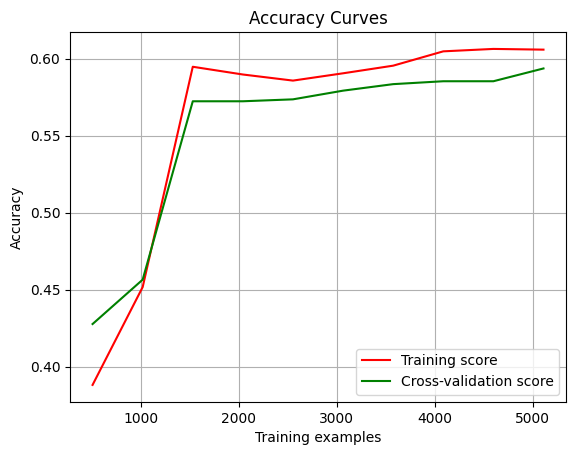

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

final_test_score = accuracy_score(y_test, best_model.predict(X_test_scaled))

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_scaled, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Accuracy Curves")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.grid()
plt.plot(train_sizes, train_scores_mean,  color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, color="g", label="Cross-validation score")
plt.legend()
plt.show()

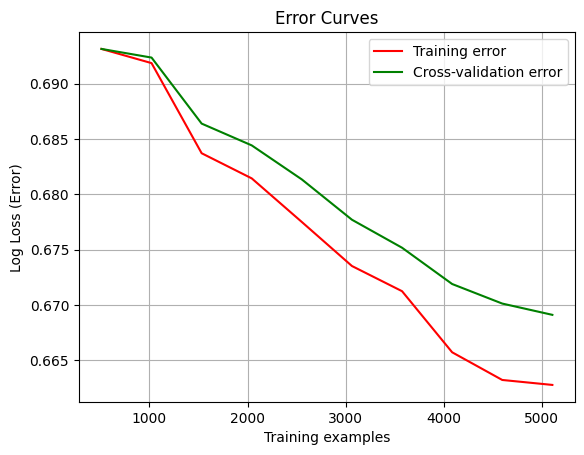

In [49]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_scaled, y_train, cv=5, scoring='neg_log_loss',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_errors_mean = -np.mean(train_scores, axis=1)
train_errors_std = np.std(train_scores, axis=1)
test_errors_mean = -np.mean(test_scores, axis=1)
test_errors_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Error Curves")
plt.xlabel("Training examples")
plt.ylabel("Log Loss (Error)")
plt.grid()
plt.plot(train_sizes, train_errors_mean,  color="r", label="Training error")
plt.plot(train_sizes, test_errors_mean,  color="g", label="Cross-validation error")
plt.legend()
plt.show()

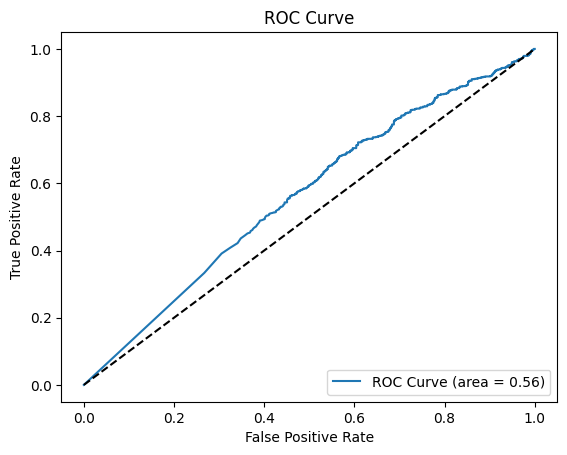

In [51]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()